# Validation Layer

## **Description:**

- Now you have to create validation schema and produce simple model running on it
    - Create a validation class
    - Create a simpe model
    - Create a simpe feature extraction step
- No extensive modeling or feature extraction is required, we need just to ensure our modeling step is trustworthy:
    - We don't have any target leakage
    - Our validation results are very close to the production behaviour
    - We have enough validation data to rank our model results
- Prepare a simple picture that would describe your schema:
    - Decalre Train/Validation/Test splits
    - Define validation approach
    - Define the way you exrtact features that won't have target or data leakage

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import scripts.validate as validate # validate.py module

## Load and transform **train, test** datasets

In [26]:
train_df = pd.read_csv('../data/result_train.csv')
test_df = pd.read_csv('../data/result_test.csv')

In [27]:
float_columns = train_df.select_dtypes(include=np.number).columns.tolist()
object_columns = train_df.select_dtypes(include=object).columns.tolist()

train_df = validate.transform_df_types(train_df, int_columns=[], float_columns=float_columns, object_columns=object_columns)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 37 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   date_block_num                  1608724 non-null  float32 
 1   shop_id                         1608724 non-null  float32 
 2   item_id                         1608724 non-null  float32 
 3   item_cnt_month                  1608724 non-null  float32 
 4   item_price                      1608724 non-null  float32 
 5   month                           1608724 non-null  float32 
 6   year                            1608724 non-null  float32 
 7   item_name                       1608724 non-null  category
 8   item_category_id                1608724 non-null  float32 
 9   item_category_name              1608724 non-null  category
 10  shop_name                       1608724 non-null  category
 11  months_since_last_sale          1608724 non-null  

In [28]:
float_columns = test_df.select_dtypes(include=np.number).columns.tolist()
object_columns = test_df.select_dtypes(include=object).columns.tolist()

test_df = validate.transform_df_types(test_df, int_columns=[], float_columns=float_columns, object_columns=object_columns)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214284 entries, 0 to 214283
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   ID                              214284 non-null  float32 
 1   shop_id                         214284 non-null  float32 
 2   item_id                         214284 non-null  float32 
 3   item_name                       214284 non-null  category
 4   item_category_id                214284 non-null  float32 
 5   item_category_name              214284 non-null  category
 6   shop_name                       214284 non-null  category
 7   months_since_last_sale          214284 non-null  float32 
 8   revenue_lag_1                   214284 non-null  float32 
 9   revenue_lag_2                   214284 non-null  float32 
 10  revenue_lag_3                   214284 non-null  float32 
 11  revenue_lag_6                   214284 non-null  float32 
 12  re

## Build a simple validation split class

In [29]:
class TimeSeriesSplit:
    def __init__(self, n_splits=5, train_start=0):
        self.n_splits = n_splits # the number of train:test pairs to return
        self.train_start = train_start

    def split(self, X):
        n_months = X['date_block_num'].max() + 1

        for i in range(self.n_splits, 0, -1):
            train_idx = (X['date_block_num'] < n_months - i) & (X['date_block_num'] >= self.train_start)
            test_idx = X['date_block_num'] == n_months - i

            yield train_idx, test_idx

In [30]:
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split(train_df):
    train = train_df[train_idx]
    test = train_df[test_idx]
    print("Train set months:", train['date_block_num'].min(), train['date_block_num'].max())
    print("Test set months", test['date_block_num'].min(), test['date_block_num'].max())
    print()

Train set months: 0.0 28.0
Test set months 29.0 29.0

Train set months: 0.0 29.0
Test set months 30.0 30.0

Train set months: 0.0 30.0
Test set months 31.0 31.0

Train set months: 0.0 31.0
Test set months 32.0 32.0

Train set months: 0.0 32.0
Test set months 33.0 33.0



## Clean train set from unneeded columns

In [31]:
train_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'month', 'year', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'months_since_last_sale', 'revenue', 'revenue_lag_1',
       'revenue_lag_2', 'revenue_lag_3', 'revenue_lag_6', 'revenue_lag_12',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'item_cnt_month_cat__lag_1', 'item_cnt_month_cat__lag_2',
       'item_cnt_month_cat__lag_3', 'item_cnt_month_cat_shop__lag_1',
       'item_cnt_month_cat_shop__lag_2', 'item_cnt_month_cat_shop__lag_3',
       'days', 'avg_item_price', 'avg_item_price_lag_1',
       'avg_item_price_lag_2', 'avg_item_price_lag_3', 'avg_item_price_lag_4',
       'avg_item_price_lag_5', 'avg_item_price_lag_6'],
      dtype='object')

In [32]:
train = train_df.select_dtypes(include=np.number)
y = train['item_cnt_month']
X = train.drop(['item_cnt_month', 'item_price', 'revenue', 'avg_item_price'], axis=1, inplace=False)

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 30 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1608724 non-null  float32
 1   shop_id                         1608724 non-null  float32
 2   item_id                         1608724 non-null  float32
 3   month                           1608724 non-null  float32
 4   year                            1608724 non-null  float32
 5   item_category_id                1608724 non-null  float32
 6   months_since_last_sale          1608724 non-null  float32
 7   revenue_lag_1                   1608724 non-null  float32
 8   revenue_lag_2                   1608724 non-null  float32
 9   revenue_lag_3                   1608724 non-null  float32
 10  revenue_lag_6                   1608724 non-null  float32
 11  revenue_lag_12                  1608724 non-null  float32
 12  

## Train simple model

In [34]:
from sklearn.metrics import mean_squared_error

In [35]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [36]:
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [61]:
model = XGBRegressor(
    max_depth=9,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42,
    eval_metric="rmse",
    early_stopping_rounds=20)

scores = []

In [69]:
tscv = TimeSeriesSplit(n_splits=3)

for train_idx, test_idx in tscv.split(X):
    X_new = X.copy()
    X_new.drop('date_block_num', axis=1, inplace=True)
    X_train, X_test = X_new[train_idx], X_new[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    print(len(X_train), len(X_test), len(y_train), len(y_test))
    
    model = XGBRegressor(
    max_depth=7,
    n_estimators=1000,
    # min_child_weight=300, 
    # colsample_bytree=0.8, 
    # subsample=0.8, 
    eta=0.05,    
    # seed=42,
    eval_metric="rmse",
    early_stopping_rounds=30)

    model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True)

    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    print(f"RMSE: {score:.2f}")
    print()

1514030 33486 1514030 33486
[0]	validation_0-rmse:2.53726	validation_1-rmse:2.05478
[1]	validation_0-rmse:2.48956	validation_1-rmse:2.01667
[2]	validation_0-rmse:2.44507	validation_1-rmse:1.98185
[3]	validation_0-rmse:2.40434	validation_1-rmse:1.94860
[4]	validation_0-rmse:2.36693	validation_1-rmse:1.91857
[5]	validation_0-rmse:2.33216	validation_1-rmse:1.89122
[6]	validation_0-rmse:2.30040	validation_1-rmse:1.86464
[7]	validation_0-rmse:2.27028	validation_1-rmse:1.84022
[8]	validation_0-rmse:2.24294	validation_1-rmse:1.81721
[9]	validation_0-rmse:2.21760	validation_1-rmse:1.79679
[10]	validation_0-rmse:2.19398	validation_1-rmse:1.77842
[11]	validation_0-rmse:2.17213	validation_1-rmse:1.76102
[12]	validation_0-rmse:2.15245	validation_1-rmse:1.74393
[13]	validation_0-rmse:2.13395	validation_1-rmse:1.72893
[14]	validation_0-rmse:2.11705	validation_1-rmse:1.71549
[15]	validation_0-rmse:2.10134	validation_1-rmse:1.70262
[16]	validation_0-rmse:2.08704	validation_1-rmse:1.69122
[17]	validati

In [70]:
print(f"RMSE: {np.mean(scores):.2f}")

RMSE: 1.78


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

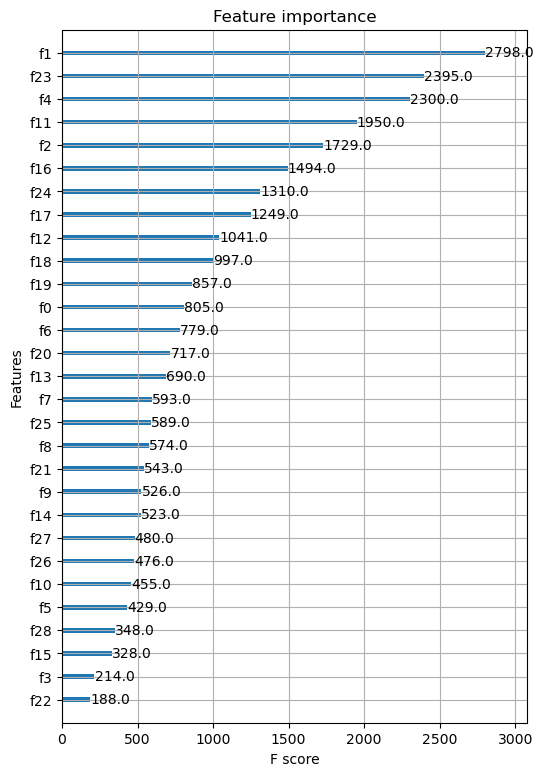

In [71]:
plot_features(model, (6, 9))